# Imports
---

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, make_scorer, recall_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Data Loading, Exploration and Preprocessing
---

In [16]:
cols = ['Flyer_Miles/Year', 'Percent_Time_Gaming', 'IceCream_Liters/Week', 'Class']

In [68]:
train_dating = pd.read_csv(filepath_or_buffer="./datingData_training.txt", sep="\t", names=cols)
test_dating = pd.read_csv(filepath_or_buffer="./datingData_test.txt", sep="\t", names=cols)

train_dating_X = train_dating.iloc[:,-2::-1]
train_dating_Y = train_dating.iloc[:,-1]
test_dating_X = test_dating.iloc[:,-2::-1]
test_dating_Y = test_dating.iloc[:,-1]

# dating_X = pd.concat([train_dating_X, test_dating_X], axis=0)
# dating_Y = pd.concat([train_dating_Y, test_dating_Y], axis=0)

dating_X = train_dating_X
dating_Y = train_dating_Y

In [69]:
display(dating_X.head())
display(dating_Y.head())

,IceCream_Liters/Week,Percent_Time_Gaming,Flyer_Miles/Year
0,0.953952,8.326976,40920
1,1.673904,7.153469,14488
2,0.805124,1.441871,26052
3,0.428964,13.147394,75136
4,0.134296,1.669788,38344


0    largeDoses
1    smallDoses
2     didntLike
3     didntLike
4     didntLike
Name: Class, dtype: object

### Label Encoding and Standardizing

In [70]:
standard_scaler = StandardScaler()
label_encoder = LabelEncoder()

dating_X = pd.DataFrame(standard_scaler.fit_transform(dating_X), columns=cols[:len(cols)-1])
dating_Y = pd.Series(label_encoder.fit_transform(dating_Y), name='class')

test_dating_X = pd.DataFrame(standard_scaler.fit_transform(test_dating_X), columns=cols[:len(cols)-1])
test_dating_Y = pd.Series(label_encoder.fit_transform(test_dating_Y), name='class')

display(dating_X.head())
display(dating_Y.head())
display(dating_Y.value_counts().head())

,Flyer_Miles/Year,Percent_Time_Gaming,IceCream_Liters/Week
0,0.270115,0.404833,0.297354
1,1.747063,0.127640,-0.916683
2,-0.035199,-1.221490,-0.385542
3,-0.806873,1.543459,1.868916
4,-1.411371,-1.167654,0.179037


0    1
1    2
2    0
3    0
4    0
Name: class, dtype: int64

class
0    220
1    200
2    180
Name: count, dtype: int64

### Visualizing feature distributions

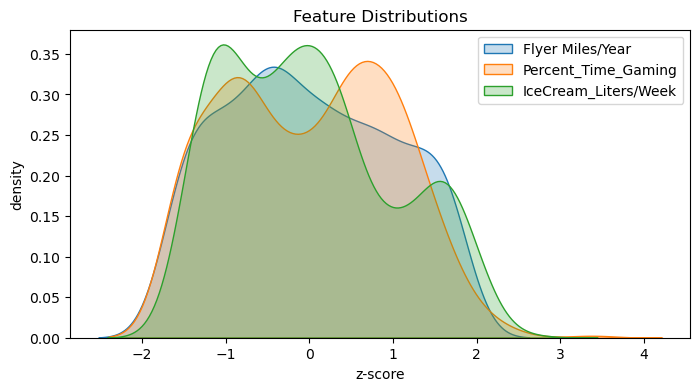

In [71]:
plt.figure(figsize=(8,4))

sns.kdeplot(dating_X['Flyer_Miles/Year'], fill=True, label='Flyer Miles/Year')
sns.kdeplot(dating_X['Percent_Time_Gaming'], fill=True, label='Percent_Time_Gaming')
sns.kdeplot(dating_X['IceCream_Liters/Week'], fill=True, label='IceCream_Liters/Week')
plt.title("Feature Distributions")
plt.xlabel("z-score")
plt.ylabel("density")
plt.legend()
plt.show()

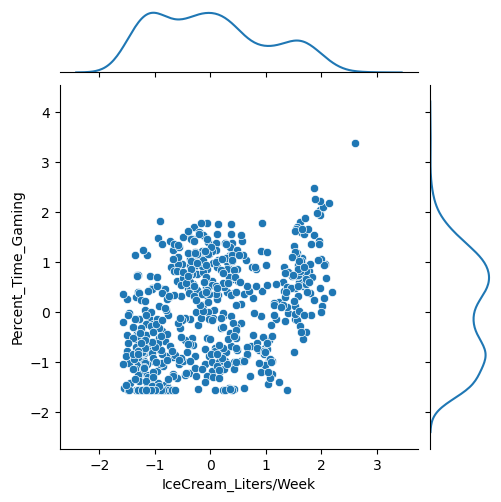

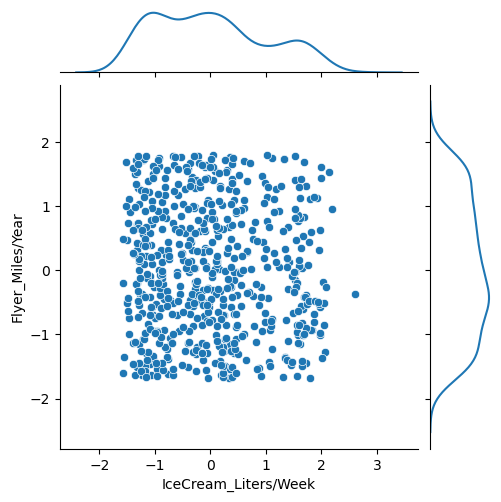

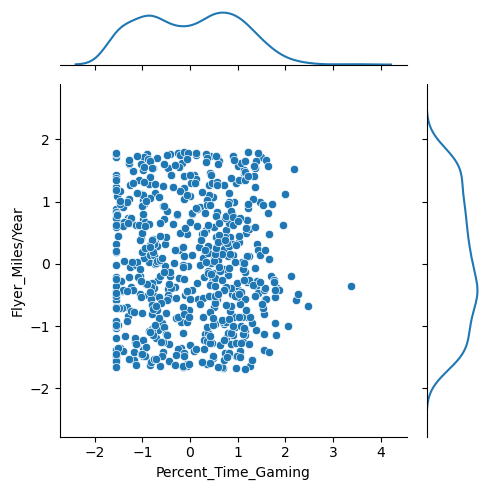

In [72]:
import itertools

for i, p in enumerate(itertools.combinations(cols[-2::-1], r=2)):
    g = sns.JointGrid(x=p[0], y=p[1], data=dating_X)
    g = g.plot(sns.scatterplot, sns.kdeplot)
    g.figure.set_size_inches(5, 5)
    g.set_axis_labels(p[0], p[1])
    g.ax_joint.set_xlim

plt.tight_layout()
plt.show()

### Useful Functions

In [22]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted'),
    'recall' : make_scorer(recall_score, average='weighted')
    }
def cross_validation(X, Y, scoring, model, folds=10):
    cv_results = pd.DataFrame(cross_validate(model, X, Y, scoring=scoring, cv=folds),
                              index=np.arange(1,folds+1)).iloc[:,2:]
    cv_results.columns = ['accuracy', 'precision', 'f1-measure', 'recall']
    cv_results.index.name = 'trials'
    return cv_results

def holdout(X, Y, trials, percent_train, shuffle, dataset_title="", criterion="gini"):
    
    accuracies = []
    precisions = []
    f1_measures = []

    for t in range(trials):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=percent_train, shuffle=shuffle)
    
        clf = tree.DecisionTreeClassifier(criterion=criterion)
        clf.fit(X_train,Y_train)
        Y_pred = clf.predict(X_test)
    
        accuracies.append(accuracy_score(Y_test, Y_pred))
        precisions.append(precision_score(Y_test, Y_pred, average='weighted'))
        f1_measures.append(f1_score(Y_test, Y_pred, average='weighted'))

    clf_trials = pd.DataFrame({
                    'accuracy': accuracies,
                    'precision': precisions,
                    'f1-measure': f1_measures,
                    }, index=np.arange(start=1, stop=trials+1))
    clf_trials.index.name = 'trials'

    display(clf_trials)

    clf_trials.mean().plot(kind='bar', ylim=[0,1], ylabel='Score', title=f'Average Holdout Trial Performance\nfor {dataset_title}')
    plt.xticks(rotation=0)
    plt.xlabel('Metric', labelpad=15)
    plt.grid(True)
    plt.show()
    return clf_trials

# Naive Bayes Classification (Assuming Gaussian Distribution)
---

Although some correlation can be observed between **gaming time** and **ice cream consumed**, Gaussian Naive Bayes remains a robust classification method due to the roughly normal feature distributions and no correlation between other feature pairs.

In [23]:
gnb = GaussianNB()

NaiveBayesResults = cross_validation(dating_X, dating_Y,
                                     scoring=scoring, model=gnb, folds=10)
NaiveBayesResults.mean()



accuracy      0.935000
precision     0.937537
f1-measure    0.934323
recall        0.935000
dtype: float64

# K-NN Classification
---

### Model Selection

- Determining the best value for K

In [47]:
numNeighbors = np.arange(1,31)
bestk = defaultdict(int)
for epoch in range(1000):
    testAcc = np.array([])
    X_train, X_test, Y_train, Y_test = train_test_split(dating_X, dating_Y,
                                                        test_size=0.1, shuffle=True,)    
    for k in numNeighbors:
        clf = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
        clf.fit(X_train, Y_train)
        Y_predTest = clf.predict(X_test)
        testAcc = np.append(testAcc, accuracy_score(Y_test, Y_predTest))
    bestkIndex = np.where(testAcc == max(testAcc))[0][0]
    bestk[numNeighbors[bestkIndex]] += 1
# Create a bar plot
keys = list(bestk.keys())
values = list(bestk.values())
plt.figure(figsize=(6,4))
plt.bar(keys, values)
plt.xlabel('k')
plt.xticks(np.concat([np.array([1]),np.arange(5, 31,5)]))
plt.ylabel('Count')
plt.title('K Values with Best Test Accuracy over 1000 epochs')
plt.show()

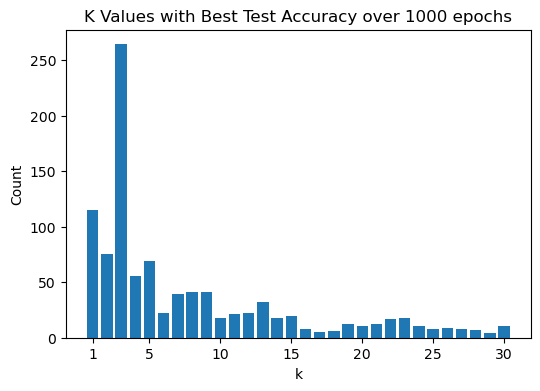

In [49]:
# Create a bar plot
keys = list(bestk.keys())
values = list(bestk.values())
plt.figure(figsize=(6,4))
plt.bar(keys, values)
plt.xlabel('k')
plt.xticks(np.concat([np.array([1]),np.arange(5, 31,5)]))
plt.ylabel('Count')
plt.title('K Values with Best Test Accuracy over 1000 epochs')
plt.show()

### Validation

In [46]:
clf = KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=2)

k_NN_Results = cross_validation(dating_X, dating_Y,
                                     scoring=scoring, model=clf, folds=10)
k_NN_Results.mean()

accuracy      0.952000
precision     0.953412
f1-measure    0.951685
recall        0.952000
dtype: float64

# Decision Tree Classification
---

### Model Selection
- selecting the best impurity measure and maximum tree depth

In [50]:
maxDepths = [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]
testAcc_GINI = np.zeros(shape=(len(maxDepths)))
testAcc_ENTROPY = np.zeros(shape=(len(maxDepths)))
for epoch in range(1000):
    X_train, X_test, Y_train, Y_test = train_test_split(dating_X, dating_Y,
                                                        test_size=0.1, shuffle=True,)
    for i,d in enumerate(maxDepths):
        clf_GINI = DecisionTreeClassifier(criterion='gini', max_depth=d)
        clf_ENTROPY = DecisionTreeClassifier(criterion='entropy', max_depth=d)
        Y_pred_GINI = clf_GINI.fit(X_train, Y_train).predict(X_test)
        Y_pred_ENTROPY = clf_ENTROPY.fit(X_train, Y_train).predict(X_test)
        testAcc_GINI[i] += accuracy_score(Y_test, Y_pred_GINI)
        testAcc_ENTROPY[i] += accuracy_score(Y_test, Y_pred_ENTROPY)
testAcc_ENTROPY = testAcc_ENTROPY/1000
testAcc_GINI = testAcc_GINI/1000

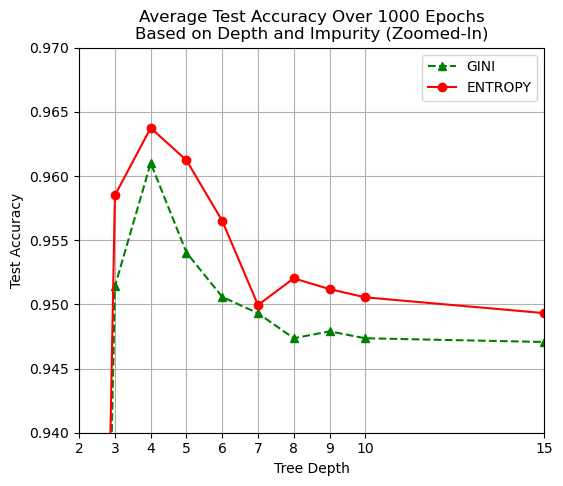

In [64]:
plt.figure(figsize=(6,5))
plt.plot(maxDepths, testAcc_GINI, 'g^--', label="GINI")
plt.plot(maxDepths, testAcc_ENTROPY, 'ro-', label="ENTROPY")
plt.legend()
plt.title('Average Test Accuracy Over 1000 Epochs\nBased on Depth and Impurity (Zoomed-In)')
plt.xlabel('Tree Depth')
plt.ylabel('Test Accuracy')
plt.xticks(maxDepths)
plt.ylim([0.94,0.97])
plt.xlim([2,15])
plt.grid()
plt.show()

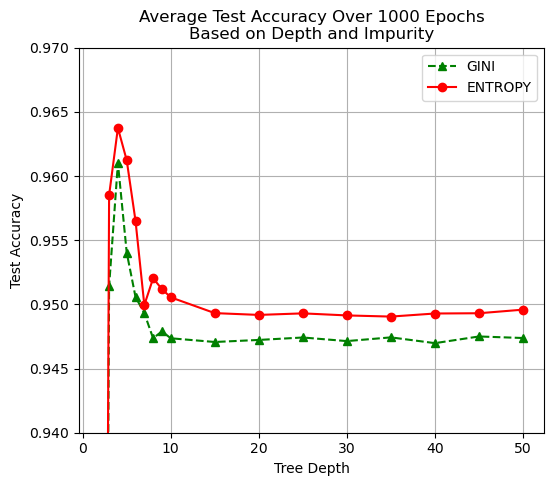

In [63]:
plt.figure(figsize=(6,5))
plt.plot(maxDepths, testAcc_GINI, 'g^--', label="GINI")
plt.plot(maxDepths, testAcc_ENTROPY, 'ro-', label="ENTROPY")
plt.legend()
plt.title('Average Test Accuracy Over 1000 Epochs\nBased on Depth and Impurity')
plt.xlabel('Tree Depth')
plt.ylabel('Test Accuracy')
plt.ylim([0.94,0.97])
plt.grid()
plt.show()

In [73]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4)

tree_Results = cross_validation(dating_X, dating_Y,
                                     scoring=scoring, model=clf, folds=10)
tree_Results.mean()

,accuracy,precision,f1-measure,recall
trials,,,,
1,0.983333,0.984058,0.983280,0.983333
2,0.933333,0.933333,0.933333,0.933333
3,0.950000,0.951587,0.950372,0.950000
4,0.933333,0.938456,0.933308,0.933333
5,0.916667,0.917689,0.915907,0.916667
6,0.950000,0.956000,0.950480,0.950000
7,0.983333,0.984058,0.983305,0.983333
8,0.933333,0.940211,0.931451,0.933333
9,1.000000,1.000000,1.000000,1.000000
